In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

In [2]:
syscov = np.loadtxt('data/pantheon_errors.txt',skiprows=1).reshape((1048,1048))
print(np.min(syscov), np.max(syscov), np.mean(syscov))

-0.00033653 0.00362865 8.662339843977609e-08


In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
            print(i,j)
            print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

358 820
8.16e-05 8.1595e-05
517 810
3.7935e-05 3.794e-05
517 957
3.7935e-05 3.794e-05


3

In [4]:
file = 'data/pantheon.txt'
data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'] )
# X = data.values[:,0]
staterr = data.values[:,2]

In [5]:
covfull = np.copy(syscov)
covfull[np.diag_indices_from(covfull)] += staterr**2
print(np.shape(syscov), np.shape(covfull))
mincov = np.min(covfull)
maxcov = np.max(covfull)
meancov = np.mean(covfull)
print(mincov, maxcov, meancov)

(1048, 1048) (1048, 1048)
-0.00033653 0.20346321749999996 2.0207316428329494e-05


In [6]:
# df_syscov = pd.DataFrame(syscov)
# sns.heatmap(df_syscov, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno',
#             robust=True)

# plt.savefig("cov_sys.png", dpi=300)

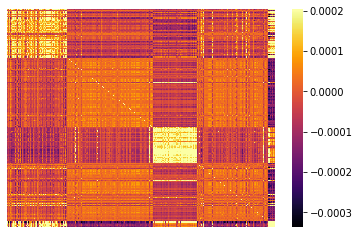

In [7]:
df_covfull = pd.DataFrame(covfull)
sns.heatmap(df_covfull, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno',
            vmax=maxcov/1e3, vmin=mincov,robust=True)
# cmaps['Perceptually Uniform Sequential'] = [
#             'viridis', 'plasma', 'inferno', 'magma', 'cividis']
# cmaps['Sequential'] = [
#             'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
#             'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
#             'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
# cmaps['Sequential (2)'] = [
#             'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
#             'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
#             'hot', 'afmhot', 'gist_heat', 'copper']


In [8]:
# Y = syscov
# # print(np.shape(dataFull))
# # randomize = np.random.permutation(len(data.values))
# shuffle = [x for x in range(len(data.values)) if x%2==0]
# odd = [x for x in range(len(data.values)) if x%2==0]
# shuffle.extend(odd)

# X = X[shuffle]
# y = Y[shuffle]

# scalerx = StandardScaler()
# scalerx.fit(X.reshape(-1,1))
# X = scalerx.transform(X.reshape(-1,1))

# # scalery = StandardScaler()
# # scalery.fit(X.reshape(-1,1))
# # Y = scalerx.transform(Y.reshape(-1,1))

# split = 0.8
# ntrain = int(split * len(X))
# indx = [ntrain]
# X_train, X_test = np.split(X, indx)
# y_train, y_test = np.split(y, indx)
# print(np.shape(syscov))

In [9]:
np.min(syscov.diagonal()) #checking non-negatives

3.5145e-05

In [10]:
syscov[0,1] == syscov[1,0]

True

In [11]:
np.min(syscov)

-0.00033653

In [12]:
# eigenval, eigenvec = sp.linalg.eigh(syscov)
eigenval, eigenvec = sp.linalg.eigh(covfull)

In [13]:
np.shape(eigenval), np.shape(eigenvec)

((1048,), (1048, 1048))

The eigenvalues are positive?

In [14]:
np.min(eigenval)

0.007366201584948819

In [15]:
count = 0

for i in range(len(eigenvec)):
    for j in range(len(eigenvec)):
        if np.iscomplex(eigenvec[i,j]):
#             print("COMPLEX")
            count+=1
#             print(i,j)
#             print(eigenvec[i,j])

print(count)

0


In [16]:
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

In [17]:
ortM = np.array(gram_schmidt_columns(np.real(eigenvec)))

In [18]:
np.shape(ortM)

(1048, 1048)

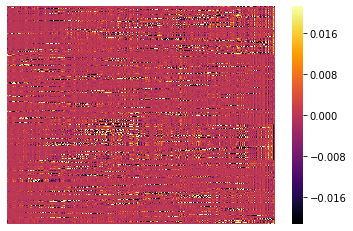

In [19]:
sns.heatmap(pd.DataFrame(ortM), annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
            robust=True)

In [20]:
Y = ortM

In [21]:
# model = tf.keras.models.Sequential([
# #         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(200, activation=tf.nn.relu, input_shape=(1,)),
# #         tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
#         tf.keras.layers.Dense(200, activation=tf.nn.relu),
# #         tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
#         tf.keras.layers.Dense(200, activation=tf.nn.relu),
# #         tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
#         tf.keras.layers.Dense(1048)
#     ])
                              
# model.compile(
#         optimizer='adam',
#         loss='mean_squared_error',
#         metrics=['mean_squared_error']
#       )

# model_train = model.fit(X_train, y_train, epochs=200, 
#           batch_size=64,verbose=1, validation_data=(X_test, y_test)) 

In [22]:
# plt.plot(model_train.history['loss'], color='r', )
# plt.plot(model_train.history['val_loss'], color='g')
# # plt.title('model loss function')
# plt.ylabel('MSE')
# plt.xlabel('Epochs')
# plt.legend(['train', 'val'], loc='upper left')
# # plt.savefig("loss_COVsn.png", dpi=200)

In [23]:
# np.max(model_train.history['val_loss'])

In [24]:
# r = np.random.uniform(0, 2.0, size=1048)
# rs = scalerx.transform(r.reshape(-1,1))
# pred_random = model.predict(rs)

In [25]:
# pred_random = pred_random[:,:1048]
# df_pred = pd.DataFrame(pred_random)
# # sns.heatmap(df_pred, annot=True, fmt='g')
# sns.heatmap(df_pred, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
#             robust=True)

In [26]:
# pred_random[81,:]


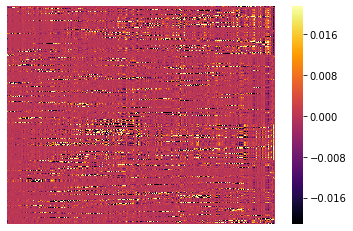

In [27]:
df_eig = pd.DataFrame(eigenvec)
sns.heatmap(df_eig, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
            robust=True)

In [28]:
input_cov = Input(shape=(1048,))
# encoded1 = Dense(600, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_cov)
encoded1 = Dense(1000, activation='relu')(input_cov)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(100, activation='relu')(encoded2)
encoded4 = Dense(10, activation='relu')(encoded3)
# encoded5 = Dense(5, activation='relu',  activity_regularizer=regularizers.l1(10e-5))(encoded4)

coded = Dense(1, activation='relu',)(encoded4)

decoded1 = Dense(10, activation='relu')(coded)
decoded2 = Dense(100, activation='relu')(decoded1)
decoded3 = Dense(500, activation='relu')(decoded2)
decoded4 = Dense(1000, activation='relu')(decoded3)
# decoded5 = Dense(200, activation='relu')(decoded4)
decoded_out = Dense(1048, activation='relu')(decoded4)


In [29]:
split = 0.8
ntrain = int(split * len(eigenvec))
indx = [ntrain]
# eigscaler = StandardScaler()
# eigenvec *= 1e10 
# eigscaler = MinMaxScaler(feature_range=(-1, 1))
# eigscaler.fit(eigenvec)
# eigenvec = eigscaler.transform(eigenvec)
evec_train, evec_test = np.split(eigenvec, indx)
evec_train, evec_test = np.split(eigenvec, indx)

autoencoder = Model(input_cov, decoded_out)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(evec_train, evec_train,
                epochs=30,
                batch_size=8,
                shuffle=True,
                validation_data=(evec_test, evec_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/30
  1/105 [..............................] - ETA: 0s - loss: 9.5420e-04WARNING:tensorflow:From /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
105/105 [==============================] - 2s 14ms/step - loss: 9.5420e-04 - val_loss: 9.5420e-04
Epoch 2/30
105/105 [==============================] - 1s 13ms/step - loss: 9.5420e-04 - val_loss: 9.5420e-04
Epoch 3/30
105/105 [==============================] - 1s 13ms/step - loss: 9.5420e-04 - val_loss: 9.5420e-04
Epoch 4/30
105/105 [==============================] - 1s 13ms/step - loss: 9.5420e-04 - val_loss: 9.5420e-04
Epoch 5/30
105/105 [==============================] - 1s 14ms/step - loss: 9.5420e-04 - val_loss: 9.5420e-04
Epoch 6/30
105/105 [==============================] - 1s 13ms/step - loss: 9.5420e-04 - val_loss: 9

In [30]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1048)]            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1049000   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

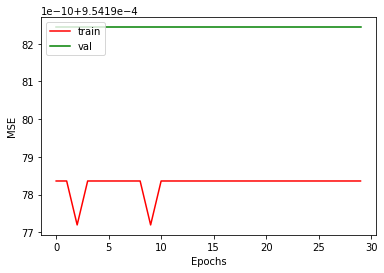

In [31]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

In [32]:
# r = np.random.uniform(0, 2.0, size=1048)
# rs = eigscaler.transform(r.reshape(-1,1))
# pred_random = autoencoder.predict(rs)
# pred_random = pred_random[:,:1048]
# df_pred = pd.DataFrame(pred_random)
# # sns.heatmap(df_pred, annot=True, fmt='g')
# sns.heatmap(df_pred, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
#             robust=True)

In [33]:
encoder = Model(input_cov, coded)
encoded_vals = encoder.predict(evec_test)
maxlatent = np.max(encoded_vals)
minlatent = np.min(encoded_vals)
print(np.min(encoded_vals), np.max(encoded_vals))
# np.mean(evec_train)


0.0 0.0


In [34]:
encoding_dim =1
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(1,))
encoded_input

<tf.Tensor 'input_2:0' shape=(None, 1) dtype=float32>

In [35]:
#The decoder model
encoding_dim = 1
encoded_input = Input(shape=(encoding_dim,), name='encoded_input')
new_decoded_1 = autoencoder.layers[-5](encoded_input)
new_decoded_2 = autoencoder.layers[-4](new_decoded_1)
new_decoded_3 = autoencoder.layers[-3](new_decoded_2)
new_decoded_4 = autoencoder.layers[-2](new_decoded_3)
new_decoded_5 = autoencoder.layers[-1](new_decoded_4)

decoder = Model(encoded_input, new_decoded_5)

In [36]:
decoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_input (InputLayer)   [(None, 1)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_7 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dense_9 (Dense)              (None, 1048)              1049048   
Total params: 1,601,668
Trainable params: 1,601,668
Non-trainable params: 0
____________________________________________

In [37]:
p = decoder.predict([1])
_, cols= np.shape(p)
cols

1048

In [38]:
c=0
for i in range(cols):
    if p[0,i]== 0.0:
        c+=1
print(c)

554


In [ ]:
r = np.random.uniform(minlatent, maxlatent, size=1048)
# r = np.linspace(minlatent, maxlatent, 1048)
# rs = eigscaler.transform(r)
pred_random = decoder.predict(r)
# pred_random = pred_random[:,:1048]
# pred_random = eigscaler.inverse_transform(pred_random)
# pred_random *= 1e-10 
# eigscaler = MinMaxScaler(feature_range=(-1, 1))
df_pred = pd.DataFrame(pred_random)
sns.heatmap(df_pred, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
            robust=True)

# sns.heatmap(df_eig, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
#             robust=True)

In [ ]:
pred_random